In [2]:
import math
import operator
from pathlib import Path

from ipywidgets import fixed, interact
import ipywidgets as widgets
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import describe, gaussian_kde
import seaborn as sns
import sys

sys.path.insert(1, './DET-tutorial-python')
from DET import DET


mated_colour = "green"
mated_label = "Mated scores"
nonmated_colour = "red"
nonmated_label = "Non-mated scores"

figure_size = (12,6)
alpha_shade = 0.25
alpha_fill = 1.0
linewidth = 2
legend_loc = "upper left"
legend_anchor = (1.0, 1.02)
legend_cols = 1
legend_fontsize = 12
label_fontsize = 16

threshold_colour = "black"
threshold_style = "--"
round_digits = 5
sns.set(style="white", palette="muted", color_codes=True)
plt.rc("axes", axisbelow=True)

c:\Users\abade\anaconda3\lib\site-packages\matplotlib2tikz\__init__.py:31: UserWarning: matplotlib2tikz has been renamed to tikzplotlib (which is Python-3-only). matplotlib2tikz will no longer be supported.
  warnings.warn("matplotlib2tikz has been renamed to tikzplotlib (which is Python-3-only). matplotlib2tikz will no longer be supported.")


In [3]:
def descriptive_statistics(mated_scores, nonmated_scores):
    stats_labels = ["Observations", "Minimum", "Maximum", "Mean", "St. Dev.", "Skewness", "Ex. Kurtosis"]
    mated_stats = describe(mated_scores)
    mated_stats = [mated_stats.nobs, mated_stats.minmax[0], mated_stats.minmax[1], mated_stats.mean, math.sqrt(mated_stats.variance), mated_stats.skewness, mated_stats.kurtosis]
    nonmated_stats = describe(nonmated_scores)
    nonmated_stats = [nonmated_stats.nobs, nonmated_stats.minmax[0], nonmated_stats.minmax[1], nonmated_stats.mean, math.sqrt(nonmated_stats.variance), nonmated_stats.skewness, nonmated_stats.kurtosis]

    stats_system_df = pd.DataFrame(np.array([stats_labels, mated_stats, nonmated_stats]).T, columns=["Statistic", "Mated", "Non-mated"])
    stats_system_df = stats_system_df.astype({"Statistic": str, "Mated": float, "Non-mated": float})
    return stats_system_df


In [14]:
mated_scores1 = np.loadtxt('./HPC_results/embeding_matches.txt')
nonmated_scores1 = np.loadtxt('./HPC_results/embeding_nonmatches.txt')
scores_type1 = "similarity"
system_name1 = "system1"

In [5]:
stats_system1_df = descriptive_statistics(mated_scores1, nonmated_scores1)
stats_system1_df.round(round_digits).style.hide_index()

Statistic,Mated,Non-mated
Observations,2750.000000,2066532.000000
Minimum,0.024200,0.185080
Maximum,1.234260,2.685920
Mean,0.321110,1.288030
St. Dev.,0.170180,0.322560
Skewness,1.246010,-0.001940
Ex. Kurtosis,2.218870,-0.302940


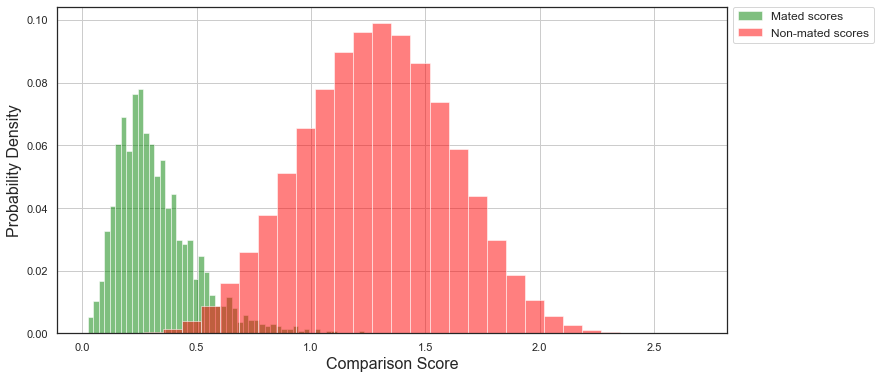

In [7]:
def plot_histogram(mated_scores, nonmated_scores, normalise=True, savename=None):
    def normalise_scores(distribution):
        return np.ones_like(distribution) / len(distribution)
    plt.figure(figsize=figure_size)
    if normalise:
        plt.hist(mated_scores, bins=50, weights=normalise_scores(mated_scores), color=mated_colour, alpha=0.5, label=mated_label)
        plt.hist(nonmated_scores, bins=30, weights=normalise_scores(nonmated_scores), color=nonmated_colour, alpha=0.5, label=nonmated_label)
        xlabel = "Probability Density"
    else:
        plt.hist(mated_scores, bins=50, color=mated_colour, alpha=0.5, label=mated_label)
        plt.hist(nonmated_scores, bins=30, color=nonmated_colour, alpha=0.5, label=nonmated_label)
        xlabel = "Count"
    plt.xlabel("Comparison Score", size=label_fontsize)
    plt.ylabel(xlabel, size=label_fontsize)
    plt.grid(True)
    plt.legend(loc=legend_loc, bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize)
    
    if savename is not None:
        plt.savefig(savename, bbox_inches="tight")
        plt.cla()
        plt.clf()
        plt.close()
    else:
        plt.show()
    
plot_histogram(mated_scores1, nonmated_scores1, normalise=True)

In [8]:
def get_kde(distribution, linspace_items=101):
    dist_min, dist_max = distribution.min(), distribution.max()
    dist_kde = gaussian_kde(distribution)
    dist_pos = np.linspace(dist_min, dist_max, linspace_items)
    return dist_kde, dist_pos, dist_min, dist_max

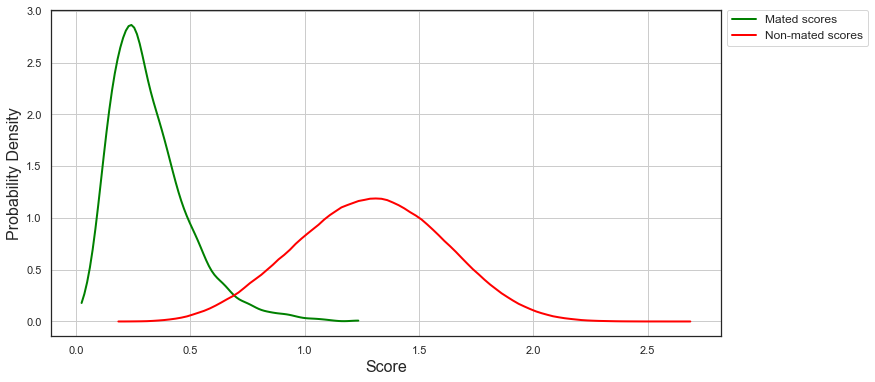

In [9]:
mated_kde, mated_pos, mated_min, mated_max = get_kde(mated_scores1)
nonmated_kde, nonmated_pos, nonmated_min, nonmated_max = get_kde(nonmated_scores1)
plt.figure(figsize=figure_size)
plt.plot(mated_pos, mated_kde(mated_pos), linewidth=linewidth, color=mated_colour, label=mated_label)
plt.plot(nonmated_pos, nonmated_kde(nonmated_pos), linewidth=linewidth, color=nonmated_colour, label=nonmated_label)
plt.xlabel("Score", size=label_fontsize)
plt.ylabel("Probability Density", size=label_fontsize)
plt.grid(True)
plt.legend(loc=legend_loc, bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize)
plt.show()

In [10]:
def d_prime(distribution1, distribution2):
    mean1, mean2 = np.mean(distribution1), np.mean(distribution2)
    std1, std2 = np.std(distribution1), np.std(distribution2)
    return abs(mean1 - mean2) / math.sqrt(0.5 * (std1 ** 2 + std2 ** 2))

In [11]:
d_prime_system1 = d_prime(mated_scores1, nonmated_scores1)
print("d' =", round(d_prime_system1, round_digits))

d' = 3.74961


In [40]:
def kde_with_threshold(mated_scores, nonmated_scores, scores_type, threshold, savename=None): 
    linspace_items = 101
    mated_kde, mated_pos, mated_min, mated_max = get_kde(mated_scores, linspace_items)
    nonmated_kde, nonmated_pos, nonmated_min, nonmated_max = get_kde(nonmated_scores, linspace_items)
    
    plt.figure(figsize=figure_size)
    plt.xlabel("Comparison Score", size=label_fontsize)
    plt.ylabel("Probability Density", size=label_fontsize)
    
    def compute_fills(scores_type, mated_min, mated_max, nonmated_min, nonmated_max, linspace_items):
        if scores_type == "similarity":
            if mated_min < threshold:
                mated_shade = np.linspace(threshold, mated_max, linspace_items)
                mated_fill = np.linspace(mated_min, threshold, linspace_items) 
            else:
                mated_shade = np.linspace(mated_min, mated_max, linspace_items)
                mated_fill = None
            if nonmated_max > threshold:
                nonmated_shade = np.linspace(nonmated_min, threshold, linspace_items)
                nonmated_fill = np.linspace(threshold, nonmated_max, linspace_items)
            else:
                nonmated_shade = np.linspace(nonmated_min, nonmated_max, linspace_items)
                nonmated_fill = None
        elif scores_type == "dissimilarity":
            if mated_max > threshold:
                mated_shade = np.linspace(mated_min, threshold, linspace_items)
                mated_fill = np.linspace(threshold, mated_max, linspace_items) 
            else:
                mated_shade = np.linspace(mated_min, mated_max, linspace_items)
                mated_fill = None
            if nonmated_min < threshold:
                nonmated_shade = np.linspace(threshold, nonmated_max, linspace_items)
                nonmated_fill = np.linspace(nonmated_min, threshold, linspace_items)
            else:
                nonmated_shade = np.linspace(nonmated_min, nonmated_max, linspace_items)
                nonmated_fill = None
        else:
            raise ValueError(f"Unknown type of comparison scores: {scores_type}")
        return mated_shade, mated_fill, nonmated_shade, nonmated_fill
    
    plt.plot(mated_pos, mated_kde(mated_pos), linewidth=linewidth, color=mated_colour, label=mated_label)
    plt.plot(nonmated_pos, nonmated_kde(nonmated_pos), linewidth=linewidth, color=nonmated_colour, label=nonmated_label)
     
    mated_shade, mated_fill, nonmated_shade, nonmated_fill = compute_fills(scores_type, mated_min, mated_max, nonmated_min, nonmated_max, linspace_items)
    
    plt.fill_between(mated_shade, mated_kde(mated_shade), alpha=alpha_shade, color=mated_colour) 
    plt.fill_between(nonmated_shade, nonmated_kde(nonmated_shade), alpha=alpha_shade, color=nonmated_colour) 
    
    if mated_fill is not None:
        plt.fill_between(mated_fill, mated_kde(mated_fill), alpha=alpha_fill, color=mated_colour)
    if nonmated_fill is not None:
        plt.fill_between(nonmated_fill, nonmated_kde(nonmated_fill), alpha=alpha_fill, color=nonmated_colour)

    plt.axvline(threshold, linewidth=linewidth, linestyle=threshold_style, color=threshold_colour, label="Decision threshold")
    
    plt.legend(loc=0)
    red_patch = mpatches.Patch(color=nonmated_colour, alpha=alpha_fill, label='False positives')
    green_patch = mpatches.Patch(color=mated_colour, alpha=alpha_fill, label='False negatives')
    shaded_red_patch = mpatches.Patch(color=nonmated_colour, alpha=alpha_shade, label='True negatives')
    shaded_green_patch = mpatches.Patch(color=mated_colour, alpha=alpha_shade, label='True positives')
    current_handles, _ = plt.gca().get_legend_handles_labels()
    
    plt.grid(True)
    plt.legend(loc=legend_loc, bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize, handles=[green_patch, red_patch, shaded_green_patch, shaded_red_patch]+current_handles)
    plt.xlim(0, 3)
    plt.ylim(0, None)
    
    if savename is not None:
        plt.savefig(savename, bbox_inches="tight")
        plt.cla()
        plt.clf()
        plt.close()
    else:
        plt.show()

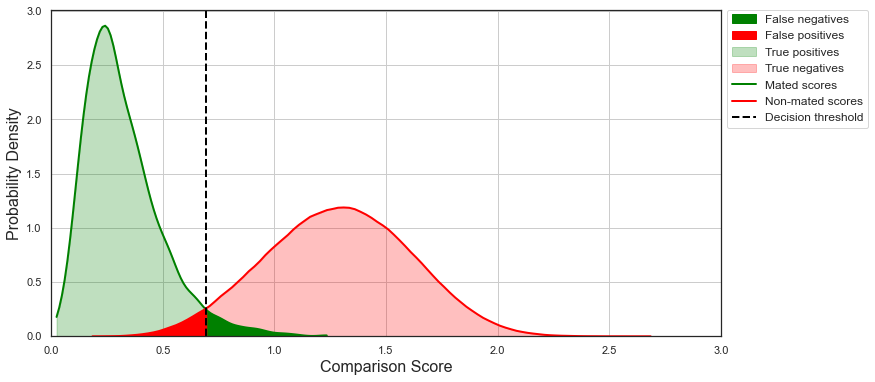

In [41]:
threshold1 = 

kde_with_threshold(mated_scores1, nonmated_scores1, scores_type1, threshold1)

In [23]:
def get_confusion_matrix(mated_scores, nonmated_scores, scores_type, threshold, mode="percent"):
    if scores_type == "similarity":
        true_accepts_count = [score >= threshold for score in mated_scores].count(True)
        true_rejects_count = [score < threshold for score in nonmated_scores].count(True)
        false_accepts_count = [score >= threshold for score in nonmated_scores].count(True)
        false_rejects_count = [score < threshold for score in mated_scores].count(True)
    elif scores_type == "dissimilarity":
        true_accepts_count = [score <= threshold for score in mated_scores].count(True)
        true_rejects_count = [score > threshold for score in nonmated_scores].count(True)
        false_accepts_count = [score <= threshold for score in nonmated_scores].count(True)
        false_rejects_count = [score > threshold for score in mated_scores].count(True)
    else:
        raise ValueError(f"Unknown type of comparison scores: {scores_type}")
    if mode == "count":
        confusion_matrix_system_df = pd.DataFrame(np.array([["Mated", "Non-mated"], [true_accepts_count, false_rejects_count], [false_accepts_count, true_rejects_count]]).T, columns=["Predicted/Actual", "Mated", "Non-mated"])
    elif mode == "percent":
        mated_count = len(mated_scores)
        nonmated_count = len(nonmated_scores)
        true_accepts_percent = true_accepts_count / mated_count * 100
        true_rejects_percent = true_rejects_count / nonmated_count * 100
        false_accepts_percent = false_accepts_count / nonmated_count * 100
        false_rejects_percent = false_rejects_count / mated_count * 100
        confusion_matrix_system_df = pd.DataFrame(np.array([["Mated", "Non-mated"], [true_accepts_percent, false_rejects_percent], [false_accepts_percent, true_rejects_percent]]).T, columns=["Predicted/Actual", "Mated", "Non-mated"])
    else:
        raise ValueError("Wrong mode: {}".format(mode))
    return confusion_matrix_system_df.astype({"Predicted/Actual": str, "Mated": float if mode == "percent" else int, "Non-mated": float if mode == "percent" else int})

def style_confusion_matrix(confusion_matrix):
    hex_color_green_fill = "#008000"
    hex_color_red_shade = "#ffbfbf"
    hex_color_green_shade = "#bfdfbf"
    hex_color_red_fill = "#ff0000"
    return confusion_matrix.style.applymap(lambda x: f'background-color: {hex_color_green_shade}', subset=pd.IndexSlice[[0], ['Mated']]).applymap(lambda x: f'background-color: {hex_color_red_fill}', subset=pd.IndexSlice[[0], ['Non-mated']]).applymap(lambda x: f'background-color: {hex_color_green_fill}', subset=pd.IndexSlice[[1], ['Mated']]).applymap(lambda x: f'background-color: {hex_color_red_shade}', subset=pd.IndexSlice[[1], ['Non-mated']]).hide_index()


Predicted/Actual,Mated,Non-mated
Mated,2650,67680
Non-mated,100,1998852


In [ ]:
scores_type1 = 'dissimilarity'
style_confusion_matrix(get_confusion_matrix(mated_scores1, nonmated_scores1, scores_type1, threshold1, mode="count"))

In [22]:
scores_type1 = 'dissimilarity'
style_confusion_matrix(get_confusion_matrix(mated_scores1, nonmated_scores1, scores_type1, threshold1, mode="percent").round(round_digits))

Predicted/Actual,Mated,Non-mated
Mated,96.363640,3.275050
Non-mated,3.636360,96.724950


In [25]:
def adjust_scores_for_DET(scores_array, scores_type):
    scores_array = np.asarray(scores_array)
    if scores_type == "similarity":
        return scores_array
    elif scores_type == "dissimilarity":
        return -scores_array
    else:
        raise ValueError(f"Unknown type of comparison scores: {scores_type}")

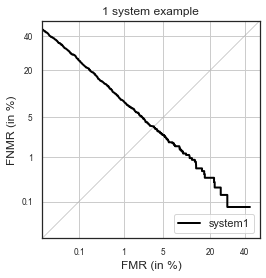

In [32]:
det = DET(biometric_evaluation_type='algorithm', abbreviate_axes=True, plot_eer_line=True, plot_title="1 system example")
det.x_limits = np.array([1e-4, .5])
det.y_limits = np.array([1e-4, .5])
det.x_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.x_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.y_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.y_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.create_figure()
det.plot(tar=adjust_scores_for_DET(mated_scores1, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label=system_name1)
det.legend_on()
det.show()

In [33]:
mated_scores1 = np.loadtxt('./HPC_results/embeding_matches.txt')
nonmated_scores1 = np.loadtxt('./HPC_results/embeding_nonmatches.txt')
scores_type1 = "dissimilarity"
system_name1 = "system1"

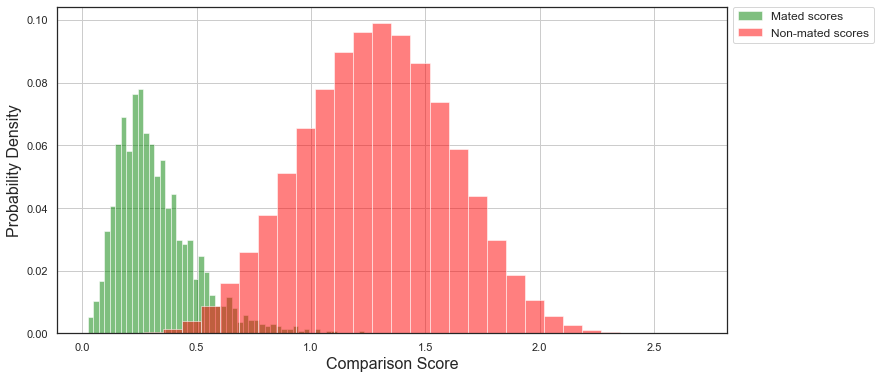

In [35]:
plot_histogram(mated_scores1, nonmated_scores1, normalise=True)